# Importing Libraries

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Loading and Exploration

In [2]:
data = pd.read_csv("/content/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.shape

(50000, 2)

# Data Preprocessing

## Label Encoding

In [4]:
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Text Preprocessing


In [5]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = text.lower()
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    tokens = cleaned_text.split()
    filtered_words = [word for word in tokens if word not in stop_words]
    processed_text = ' '.join(filtered_words)
    return processed_text

In [6]:
data['review'] = data['review'].apply(preprocess_text)
data.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


# Text Representation

In [7]:
X = data['review'].values
y = data['sentiment'].values

In [8]:
voc_size =10000
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [9]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

## Padding Sequences

In [10]:
max_len = 500
X_padded = sequence.pad_sequences(X, maxlen=max_len)
X_padded


array([[   0,    0,    0, ..., 1082, 3861,  391],
       [   0,    0,    0, ..., 1768,   13,  125],
       [   0,    0,    0, ...,   52,   10,  226],
       ...,
       [   0,    0,    0, ...,  253, 1521, 5830],
       [   0,    0,    0, ..., 2064, 4127,  595],
       [   0,    0,    0, ..., 4061,  724,    1]], dtype=int32)

# Data Splitting and Tensor Conversion

## Convert Data to PyTorch Tensors


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

## Create DataLoaders

In [12]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM Implementation

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_len):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 128, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Model Training

In [14]:
embedding_dim = 128
model = LSTMModel(voc_size, embedding_dim, max_len)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Validation Loop

In [15]:
epochs =20
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch [1/20], Train Loss: 0.5414, Validation Loss: 0.4323
Epoch [2/20], Train Loss: 0.3570, Validation Loss: 0.3300
Epoch [3/20], Train Loss: 0.2724, Validation Loss: 0.3033
Epoch [4/20], Train Loss: 0.2280, Validation Loss: 0.2851
Epoch [5/20], Train Loss: 0.1887, Validation Loss: 0.2774
Epoch [6/20], Train Loss: 0.1539, Validation Loss: 0.2970
Epoch [7/20], Train Loss: 0.1242, Validation Loss: 0.3086
Epoch [8/20], Train Loss: 0.1461, Validation Loss: 0.3719
Early stopping at epoch 8


In [39]:
scripted_model = torch.jit.script(model)
scripted_model.save('sentiment_model.pt')

# Model Evaluation


## Classification Report


In [17]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.88      0.88      4961
     Class 1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Confusion Matrix

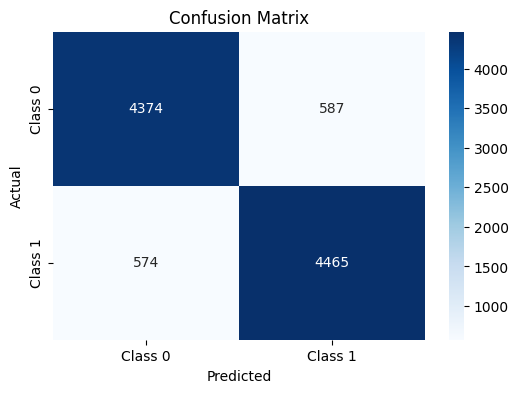

In [18]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()